In [9]:
import random
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('white')
sns.set_style('ticks')
import bcolz
import zarr
import os
import pandas as pd
import allel; print('scikit-allel', allel.__version__)

scikit-allel 1.1.8


In [10]:
release_dir = '/Volumes/Seagate Extra Storage/MalariaData/zarr2/'
callset_fn = os.path.join(release_dir, 'ag1000g.phase1.ar3.1.haplotypes')

In [11]:
callset = zarr.open_group(callset_fn, mode = 'r')
callset

Group(/, 6)
  arrays: 1; samples
  groups: 5; 2L, 2R, 3L, 3R, X
  store: DirectoryStore

In [12]:
metadata = pd.DataFrame.from_csv('/Users/NaomiCannell/Desktop/haplotypes.meta.txt', sep = '\t')
metadata.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [13]:
aom = metadata.query("population == 'AOM'")
aom.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
1236,AR0007-Ca,AR0007-C,AOM,"AR0007-Ca [Angola, Luanda, M, F]",Angola,Luanda,F,M,0.0,0.0
1237,AR0007-Cb,AR0007-C,AOM,"AR0007-Cb [Angola, Luanda, M, F]",Angola,Luanda,F,M,0.0,0.0
1238,AR0008-Ca,AR0008-C,AOM,"AR0008-Ca [Angola, Luanda, M, F]",Angola,Luanda,F,M,0.0,0.0
1239,AR0008-Cb,AR0008-C,AOM,"AR0008-Cb [Angola, Luanda, M, F]",Angola,Luanda,F,M,0.0,0.0
1240,AR0009-Ca,AR0009-C,AOM,"AR0009-Ca [Angola, Luanda, M, F]",Angola,Luanda,F,M,0.0,0.0


In [14]:
def abv_prop(vals):
    if vals.size < 100:
        return np.nan
    vals = vals[~np.isnan(vals)]
    return (sum(vals>2)/len(vals))

In [15]:
accessibility = h5py.File('/Volumes/Seagate Extra Storage/MalariaData/zarr2/accessibility.h5', mode = 'r')

In [16]:
chroms = ['2L', '2R', '3L', '3R']

Step 1 done
Step 2 done
Step 3 done
Step 4 done
Step 5 done
Step 6 done
Step 1 done
Step 2 done
Step 3 done
Step 4 done
Step 5 done
Step 6 done
Step 1 done
Step 2 done
Step 3 done
Step 4 done
Step 5 done
Step 6 done
Step 1 done
Step 2 done
Step 3 done
Step 4 done
Step 5 done
Step 6 done


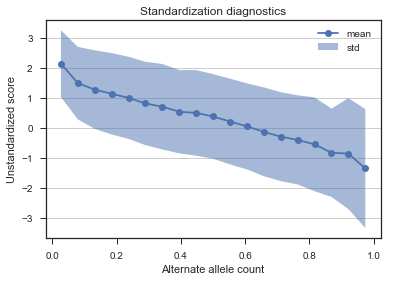

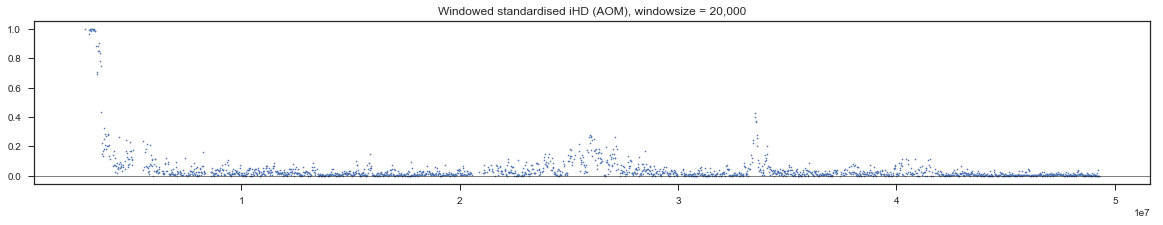

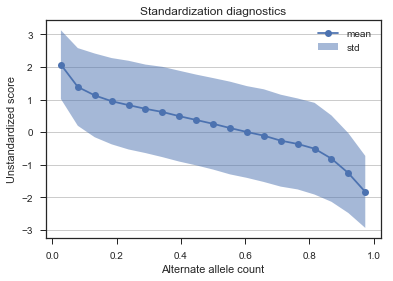

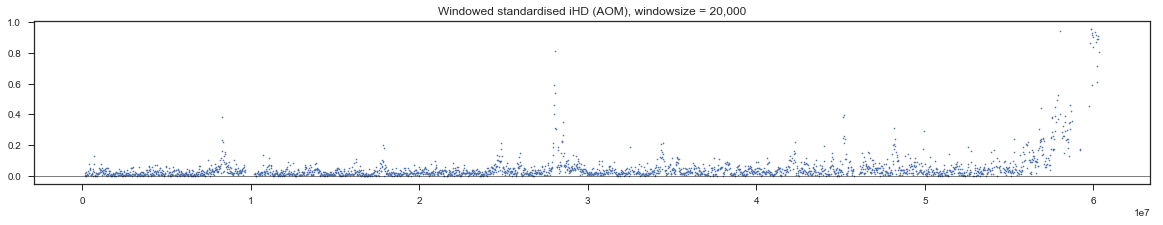

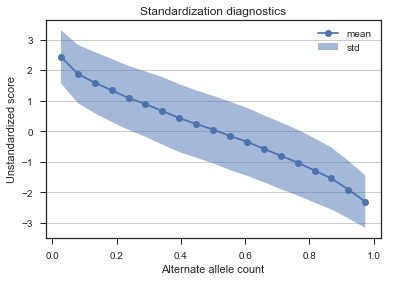

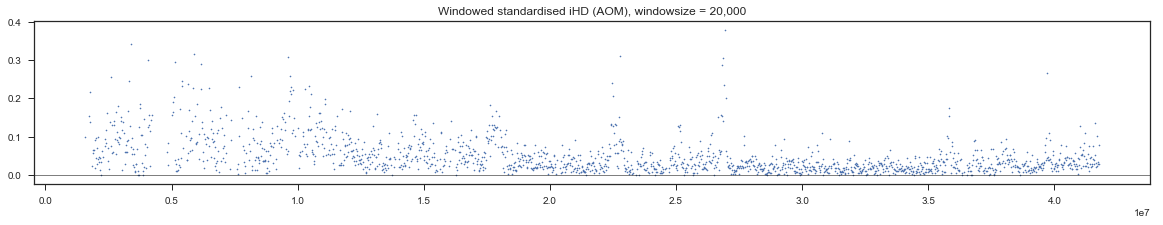

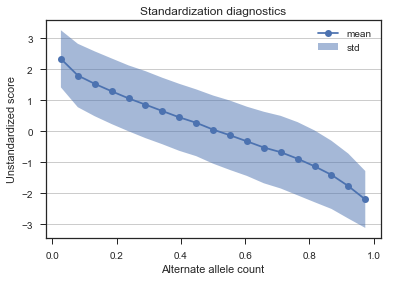

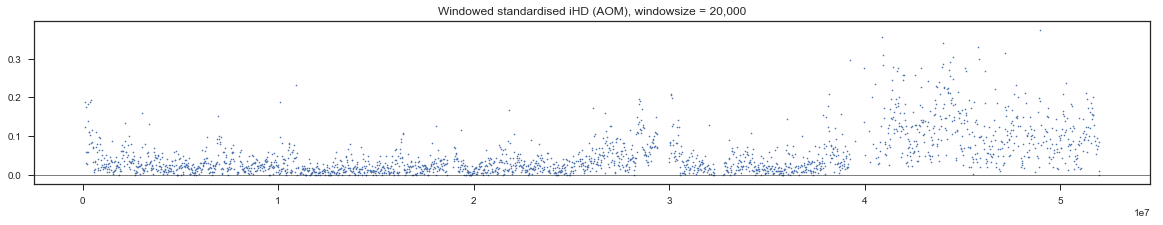

In [18]:
for chrom in chroms:
    genotypes = allel.GenotypeChunkedArray(callset[chrom]['calldata']['genotype'])
    allelecounts = genotypes.count_alleles(max_allele=1)
    singletons = allelecounts.is_singleton()
    nosinggeno = genotypes.compress(~singletons[:], axis = 0)
    haplotypes = nosinggeno.to_haplotypes()
    aom_haplo = haplotypes.take(aom.index, axis = 1)
    print('Step 1 done')
    
    positions = allel.SortedIndex(callset[chrom]['variants/POS'])
    pos = positions.compress(~singletons[:])
    print('Step 2 done')
    
    chrom_accessibility = accessibility[chrom]['is_accessible']
    aom_ihs = allel.ihs(aom_haplo, pos, use_threads = True, is_accessible = chrom_accessibility)
    print('Step 3 done')
    
    alcount_nof = allelecounts.compress(~singletons[:])
    alt_freq = alcount_nof.to_frequencies()
    alt_freq=alt_freq[:,1]

    newdata = pd.DataFrame(index = pos, columns = ['ihs', 'altfreq'])
    newdata.ihs = aom_ihs
    newdata.altfreq = alt_freq
    newdata = newdata.dropna()
    print('Step 4 done')
    
    standardised, bins = allel.standardize_by_allele_count(score=newdata.ihs, aac=newdata.altfreq, bins = np.linspace(0, 1, 20))
    newdata['std_ihs'] = standardised
    newdata.head()
    print('Step 5 done')
    
    values, windows, counts = allel.stats.windowed_statistic(pos = newdata.index, values = abs(newdata.std_ihs), statistic = abv_prop, size = 20000)
    plt.figure(figsize = (20,3))
    plt.scatter(x = windows.mean(axis=1), y=values, s=1.5)
    plt.axhline(0, color = 'black', lw = 0.5)
    plt.title('Windowed standardised iHD (AOM), windowsize = 20,000')
    print('Step 6 done')
    
    fn = ''.join(['/Users/NaomiCannell/Desktop/aom/', chrom, '_aom.csv'])
    newdata.to_csv(fn)